# Import

In [1]:
import pandas as pd
import numpy as np

import nltk
import re
import os
import json
from typing import Dict, List, Optional, Union, cast
import requests
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
import seaborn as sns

from env import github_token, github_username
import base_acquire
import wrangle

# Make sure we can see the full scale of the data
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# plotting defaults
plt.rc('figure', figsize=(11, 5))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

In [5]:
if os.path.exists('repo.csv'):
    print('Reading data from csv file...')
    df = pd.read_csv('repo.csv')
else:
    df = pd.DataFrame(base_acquire.scrape_github_data())
    # download cleaned data to a .csv
    df.to_csv('repo.csv', index=False)
    
    
    
df.head()

Reading data from csv file...


,repo,language,readme_contents
0,ccxt/ccxt,JavaScript,# CCXT – CryptoCurrency eXchange Trading Libra...
1,openssl/openssl,C,Engines\n=======\n\nDeprecation Note\n--------...
2,HelloZeroNet/ZeroNet,JavaScript,# ZeroNet [![Build Status](https://travis-ci.o...
3,freqtrade/freqtrade,Python,# ![freqtrade](https://raw.githubusercontent.c...
4,amark/gun,JavaScript,"<p id=""readme""><a href=""https://gun.eco/""><img..."


In [6]:
def clean(text: str) -> list:
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = set(nltk.corpus.stopwords.words('english'))
    text = (text.encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split() # tokenization
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [7]:
df['clean_text'] = df['readme_contents'].apply(clean).apply(' '.join)
df['language'] = df['language'].str.lower()
df.head()

,repo,language,readme_contents,clean_text
0,ccxt/ccxt,javascript,# CCXT – CryptoCurrency eXchange Trading Libra...,ccxt cryptocurrency exchange trading library b...
1,openssl/openssl,c,Engines\n=======\n\nDeprecation Note\n--------...,engine deprecation note engine api introduced ...
2,HelloZeroNet/ZeroNet,javascript,# ZeroNet [![Build Status](https://travis-ci.o...,zeronet build statushttpstravisciorghellozeron...
3,freqtrade/freqtrade,python,# ![freqtrade](https://raw.githubusercontent.c...,freqtradehttpsrawgithubusercontentcomfreqtrade...
4,amark/gun,javascript,"<p id=""readme""><a href=""https://gun.eco/""><img...",p idreadmea hrefhttpsgunecoimg width40 srchttp...


In [8]:
# Save Data to .csv
df.to_csv('repo.csv', index=False)

# Basic Exploration

In [9]:
df.language.value_counts()

javascript          26
python              23
html                19
c++                 16
jupyter notebook    12
java                 6
c                    5
ruby                 3
c#                   2
go                   2
typescript           2
tex                  2
matlab               2
shell                2
groff                1
r                    1
css                  1
g-code               1
kotlin               1
swift                1
mathematica          1
assembly             1
php                  1
objective-c          1
Name: language, dtype: int64

In [10]:
df.repo.nunique(), df.shape

(129, (132, 4))

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             132 non-null    object
 1   language         132 non-null    object
 2   readme_contents  132 non-null    object
 3   clean_text       132 non-null    object
dtypes: object(4)
memory usage: 4.2+ KB


## Takeaways
- 124 rows (unique repos), 4 columns
- 25 different coding languages
- majority are JavaScript, Python, HTML, and C++
-----------------
# Question
**Does the length of the README vary by programming language?**

In [12]:
# Get the length of text in each README
df['text_length'] = df.clean_text.apply(len)
df.head()

,repo,language,readme_contents,clean_text,text_length
0,ccxt/ccxt,javascript,# CCXT – CryptoCurrency eXchange Trading Libra...,ccxt cryptocurrency exchange trading library b...,53807
1,openssl/openssl,c,Engines\n=======\n\nDeprecation Note\n--------...,engine deprecation note engine api introduced ...,10357
2,HelloZeroNet/ZeroNet,javascript,# ZeroNet [![Build Status](https://travis-ci.o...,zeronet build statushttpstravisciorghellozeron...,3866
3,freqtrade/freqtrade,python,# ![freqtrade](https://raw.githubusercontent.c...,freqtradehttpsrawgithubusercontentcomfreqtrade...,7995
4,amark/gun,javascript,"<p id=""readme""><a href=""https://gun.eco/""><img...",p idreadmea hrefhttpsgunecoimg width40 srchttp...,14774


In [13]:
# Quick Metrics
df.text_length.describe()

count      132.000000
mean      5786.871212
std       7012.838453
min         67.000000
25%       2029.750000
50%       3799.000000
75%       7329.250000
max      53807.000000
Name: text_length, dtype: float64

<AxesSubplot:>

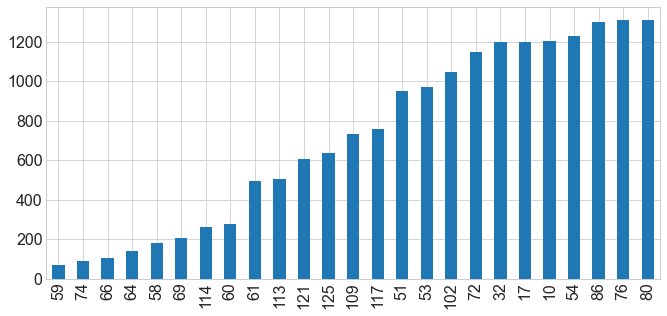

In [26]:
# Shortest 25 REAME(s)
df.clean_text.apply(len).sort_values().head(25).plot.bar()

<AxesSubplot:>

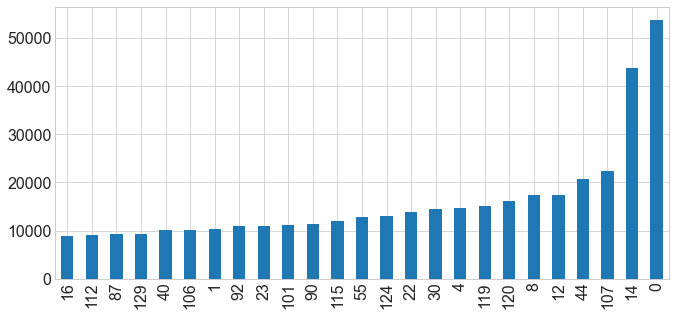

In [27]:
# Longest 25 README(s)
df.clean_text.apply(len).sort_values().tail(25).plot.bar()

<AxesSubplot:>

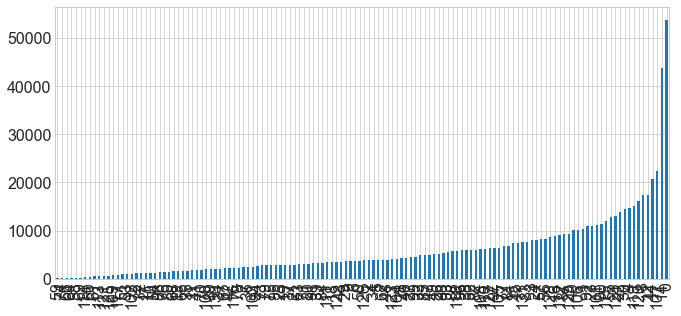

In [16]:
df.text_length.sort_values().plot.bar()

In [17]:
# there are two repos with 30,000 more text than all the others

In [18]:
df.groupby(['language']).text_length.mean().sort_values()

language
groff                 493.000000
tex                   518.500000
mathematica          1196.000000
kotlin               1732.000000
assembly             2110.000000
g-code               2194.000000
css                  2912.000000
matlab               3168.500000
jupyter notebook     3241.250000
php                  3384.000000
python               4228.086957
html                 5049.894737
r                    5145.000000
c++                  5503.937500
go                   5613.000000
shell                5821.000000
typescript           6786.500000
objective-c          7674.000000
javascript           7811.807692
java                 8456.666667
c                    9042.600000
ruby                 9699.333333
c#                  13755.000000
swift               17392.000000
Name: text_length, dtype: float64

<AxesSubplot:xlabel='language'>

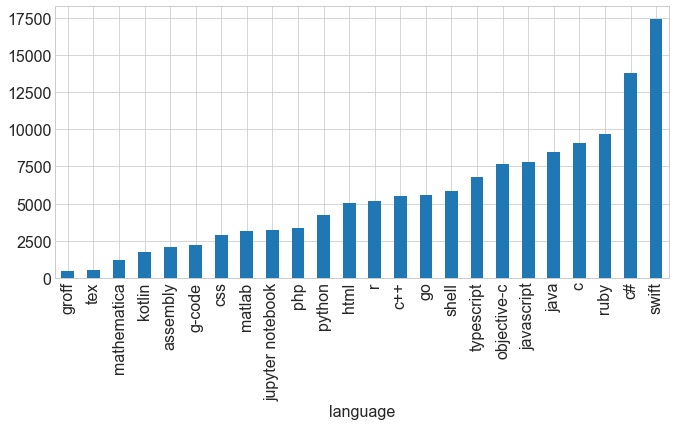

In [19]:
df.groupby(['language']).text_length.mean().sort_values().plot.bar()

# Word Counts

In [29]:
all_text = ' '.join(df.clean_text)
javascript_text = ' '.join(df[df.language == 'javascript'].clean_text)
python_text = ' '.join(df[df.language == 'python'].clean_text)
html_text = ' '.join(df[df.language == 'html'].clean_text)
cplusplus_text = ' '.join(df[df.language == 'c++'].clean_text)
jpnb_text = ' '.join(df[df.language == 'jupyter notebook'].clean_text)
java_text = ' '.join(df[df.language == 'java'].clean_text)
c_text = ' '.join(df[df.language == 'c'].clean_text)
ruby_text = ' '.join(df[df.language == 'ruby'].clean_text)
tex_text = ' '.join(df[df.language == 'c#'].clean_text)
shell_text = ' '.join(df[df.language == 'go'].clean_text)
typescript_text = ' '.join(df[df.language == 'typescript'].clean_text)
go_text = ' '.join(df[df.language == 'tex'].clean_text)
c_hashtag_text = ' '.join(df[df.language == 'matlab'].clean_text)
assembly_text = ' '.join(df[df.language == 'shell'].clean_text)
mathematica_text = ' '.join(df[df.language == 'groff'].clean_text)
css_text = ' '.join(df[df.language == 'r'].clean_text)
swift_text = ' '.join(df[df.language == 'css'].clean_text)
kotlin_text = ' '.join(df[df.language == 'g-code'].clean_text)
gcode_text = ' '.join(df[df.language == 'kotlin'].clean_text)
r_text = ' '.join(df[df.language == 'swift'].clean_text)
php_text = ' '.join(df[df.language == 'mathematica'].clean_text)
matlab_text = ' '.join(df[df.language == 'assembly'].clean_text)
groff_text = ' '.join(df[df.language == 'php'].clean_text)
objc_text = ' '.join(df[df.language == 'objective-c'].clean_text)

In [30]:
all_text = clean(all_text)
javascript_text = clean(javascript_text)
python_text = clean(python_text)
html_text = clean(html_text)
cplusplus_text = clean(cplusplus_text)
jpnb_text = clean(jpnb_text)
java_text = clean(java_text)
c_text = clean(c_text)
ruby_text = clean(ruby_text)
tex_text = clean(tex_text)
shell_text = clean(shell_text)
typescript_text = clean(typescript_text)
go_text = clean(go_text)
c_hashtag_text = clean(c_hashtag_text)
assembly_text = clean(assembly_text)
mathematica_text = clean(mathematica_text)
css_text = clean(css_text)
swift_text = clean(swift_text)
kotlin_text = clean(kotlin_text)
gcode_text = clean(gcode_text)
r_text = clean(r_text)
php_text = clean(php_text)
matlab_text = clean(matlab_text)
groff_text = clean(groff_text)
objc_text = clean(objc_text)

In [31]:
all_freq = pd.Series(str(all_text).split()).value_counts()
javascript_freq = pd.Series(str(javascript_text).split()).value_counts()
python_freq = pd.Series(str(python_text).split()).value_counts()
html_freq = pd.Series(str(html_text).split()).value_counts()
cplusplus_freq = pd.Series(str(cplusplus_text).split()).value_counts()
jpnb_freq = pd.Series(str(jpnb_text).split()).value_counts()
java_freq = pd.Series(str(java_text).split()).value_counts()
c_freq = pd.Series(str(c_text).split()).value_counts()
ruby_freq = pd.Series(str(ruby_text).split()).value_counts()
tex_freq = pd.Series(str(tex_text).split()).value_counts()
shell_freq = pd.Series(str(shell_text).split()).value_counts()
typescript_freq = pd.Series(str(typescript_text).split()).value_counts()
go_freq = pd.Series(str(go_text).split()).value_counts()
c_hashtag_freq = pd.Series(str(c_hashtag_text).split()).value_counts()
assembly_freq = pd.Series(str(assembly_text).split()).value_counts()
mathematica_freq = pd.Series(str(mathematica_text).split()).value_counts()
css_freq = pd.Series(str(css_text).split()).value_counts()
swift_freq = pd.Series(str(swift_text).split()).value_counts()
kotlin_freq = pd.Series(str(kotlin_text).split()).value_counts()
gcode_freq = pd.Series(str(gcode_text).split()).value_counts()
r_freq = pd.Series(str(r_text).split()).value_counts()
php_freq = pd.Series(str(php_text).split()).value_counts()
matlab_freq = pd.Series(str(matlab_text).split()).value_counts()
groff_freq = pd.Series(str(groff_text).split()).value_counts()
objc_freq = pd.Series(str(objc_text).split()).value_counts()

In [32]:
word_counts = pd.concat([all_freq, javascript_freq, python_freq, html_freq, cplusplus_freq, jpnb_freq, java_freq, c_freq, ruby_freq, tex_freq, shell_freq, typescript_freq, go_freq, c_hashtag_freq, assembly_freq, mathematica_freq, css_freq, swift_freq, kotlin_freq, gcode_freq, r_freq, php_freq, matlab_freq, groff_freq, objc_freq], sort=True, axis=1)
word_counts.columns = ['all', 'javascript', 'python', 'html', 'c++', 'jupyter_notebook', 'java', 'c', 'ruby', 'tex', 'shell', 'typescript', 'go', 'c#', 'assembly', 'mathematica', 'css', 'swift', 'kotlin', 'gcode', 'r', 'php', 'matlab', 'groff', 'objc']
word_counts = word_counts.fillna(0).apply(lambda s: s.astype(int))

In [36]:
# Top 25 words used in REAME(s)

top_25 = word_counts.sort_values(by='all', ascending=False).head(25)
top_25

,all,javascript,python,html,c++,jupyter_notebook,java,c,ruby,tex,shell,typescript,go,c#,assembly,mathematica,css,swift,kotlin,gcode,r,php,matlab,groff,objc
"'data',",623,73,63,266,31,35,18,18,45,4,1,4,0,3,6,1,17,1,2,3,25,0,0,6,1
"'version',",410,179,19,25,43,6,16,16,13,3,24,12,0,11,18,1,0,2,0,0,16,0,0,1,5
"'use',",401,91,61,28,52,22,14,40,16,8,8,13,2,12,1,0,0,0,3,0,18,2,0,4,6
"'run',",343,106,34,24,41,19,16,23,10,10,9,34,0,1,2,1,0,1,0,0,2,0,0,1,9
"'code',",333,61,37,44,70,18,11,37,11,9,3,6,2,5,1,1,0,6,0,0,5,0,0,5,1
"'project',",316,59,68,54,34,27,8,8,6,3,6,3,0,0,6,0,0,9,0,0,7,0,0,0,18
"'build',",309,65,11,5,87,3,12,51,35,8,10,7,0,0,0,0,0,5,0,0,8,0,0,0,0
"'using',",299,78,34,34,26,21,10,29,8,3,10,14,1,4,2,0,9,4,1,2,3,1,0,2,3
"'install',",295,85,68,15,58,9,4,9,6,11,8,10,0,0,6,0,0,3,0,0,1,0,0,0,2
"'file',",292,60,26,39,39,11,14,43,6,13,12,4,0,2,7,0,0,5,1,1,2,0,0,1,4


all  javascript  python  html  c++
170  69          6       18    12     AxesSubplot(0.125,0.125;0.775x0.755)
176  20          29      23    20     AxesSubplot(0.125,0.125;0.775x0.755)
178  38          29      33    13     AxesSubplot(0.125,0.125;0.775x0.755)
184  20          69      4     17     AxesSubplot(0.125,0.125;0.775x0.755)
187  29          26      28    31     AxesSubplot(0.125,0.125;0.775x0.755)
     42          24      20    32     AxesSubplot(0.125,0.125;0.775x0.755)
188  32          19      19    47     AxesSubplot(0.125,0.125;0.775x0.755)
191  35          21      33    24     AxesSubplot(0.125,0.125;0.775x0.755)
202  109         6       4     5      AxesSubplot(0.125,0.125;0.775x0.755)
222  23          58      8     3      AxesSubplot(0.125,0.125;0.775x0.755)
228  57          19      21    59     AxesSubplot(0.125,0.125;0.775x0.755)
     60          41      39    20     AxesSubplot(0.125,0.125;0.775x0.755)
247  239         0       1     0      AxesSubplot(0.125,0.125;0.7

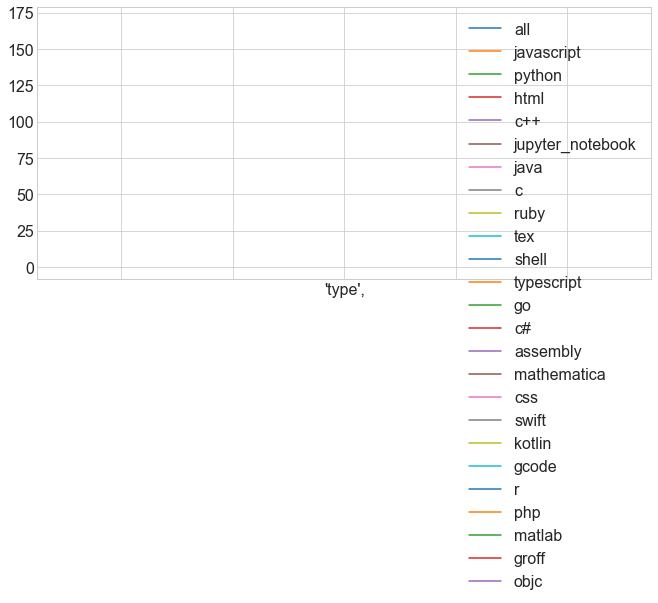

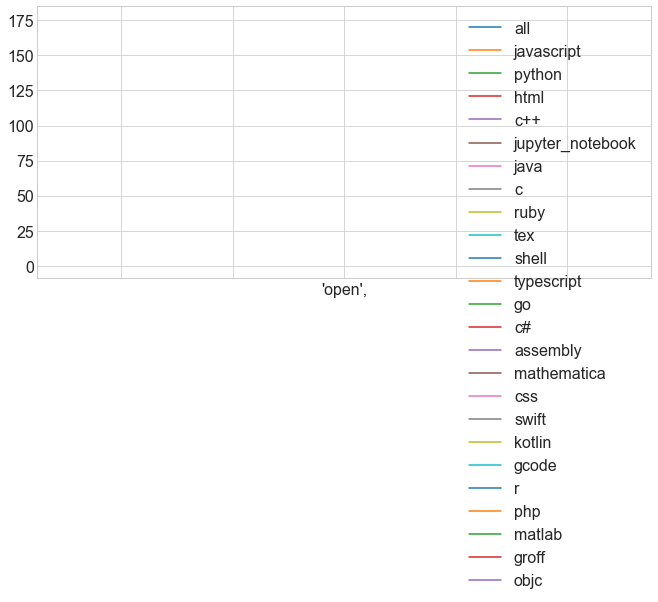

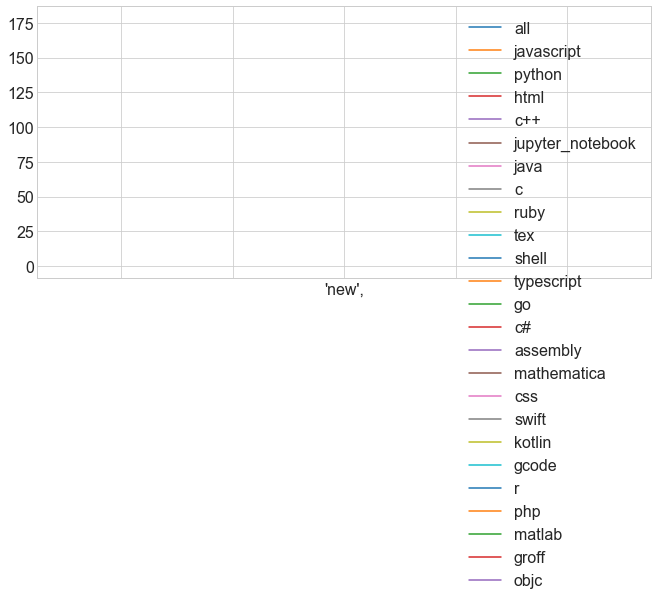

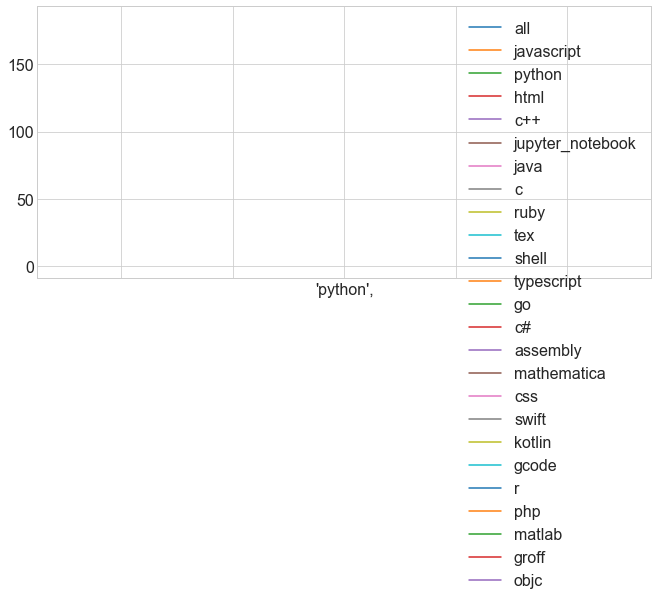

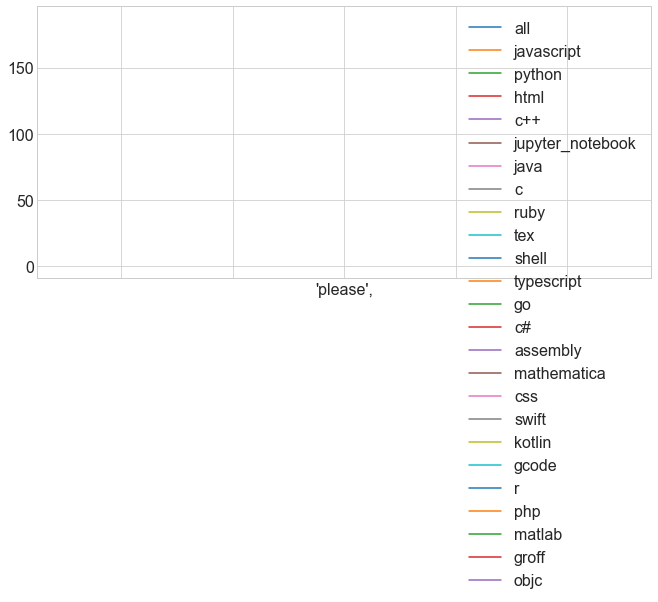

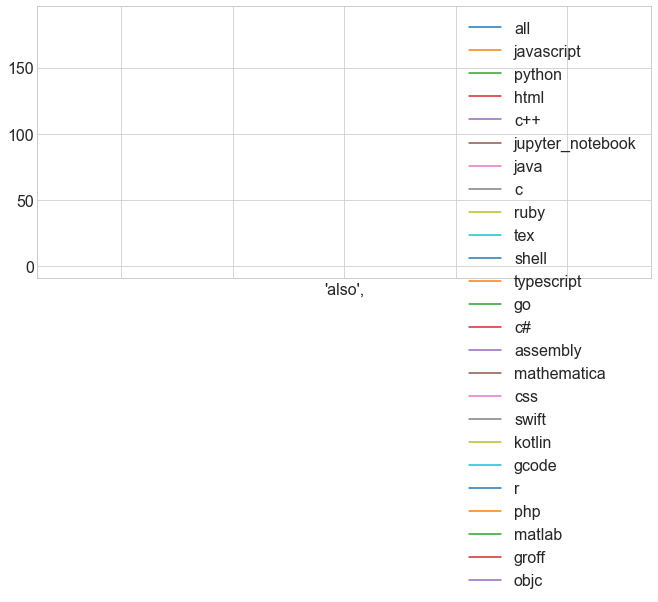

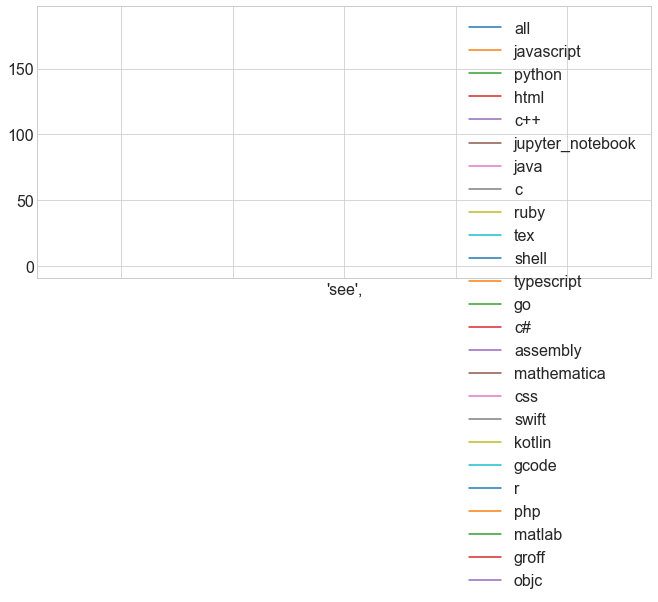

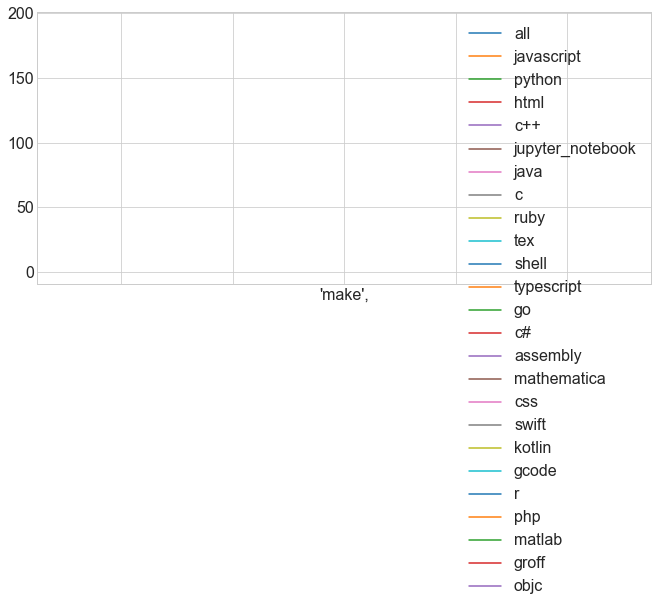

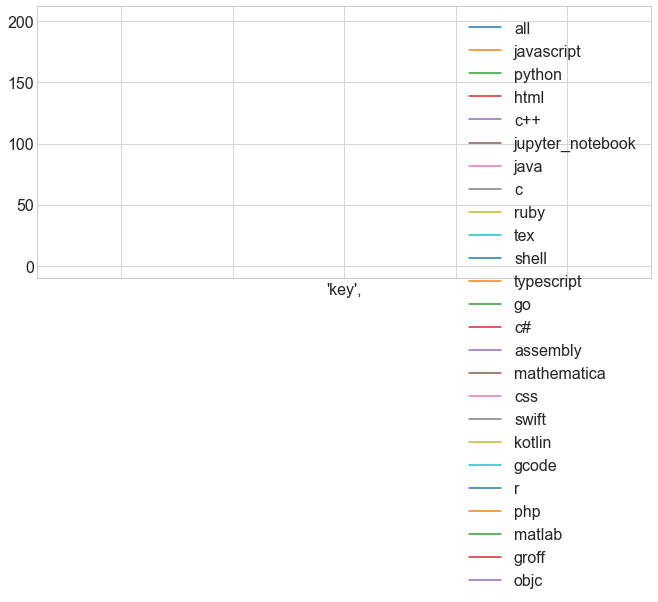

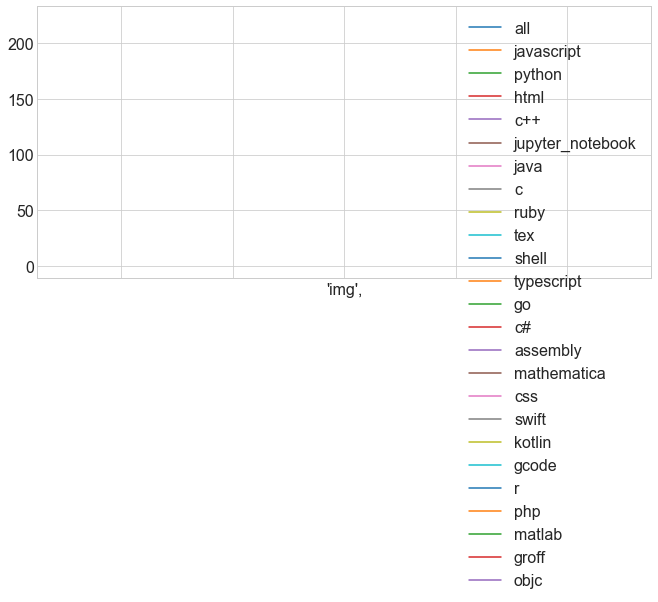

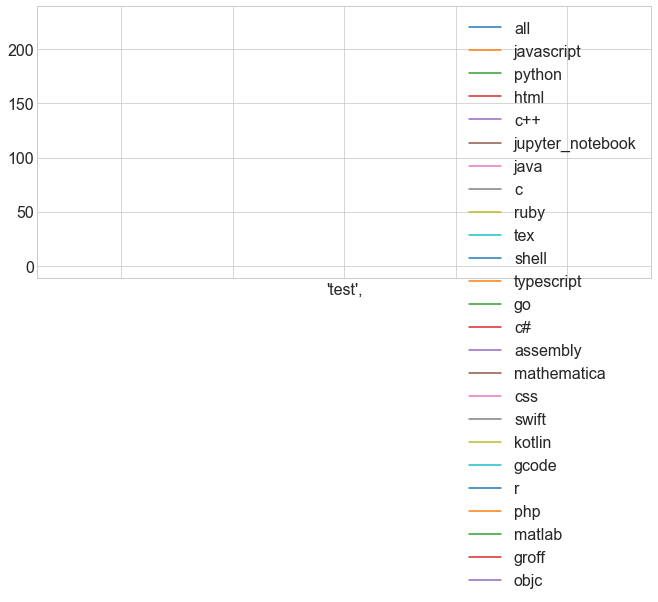

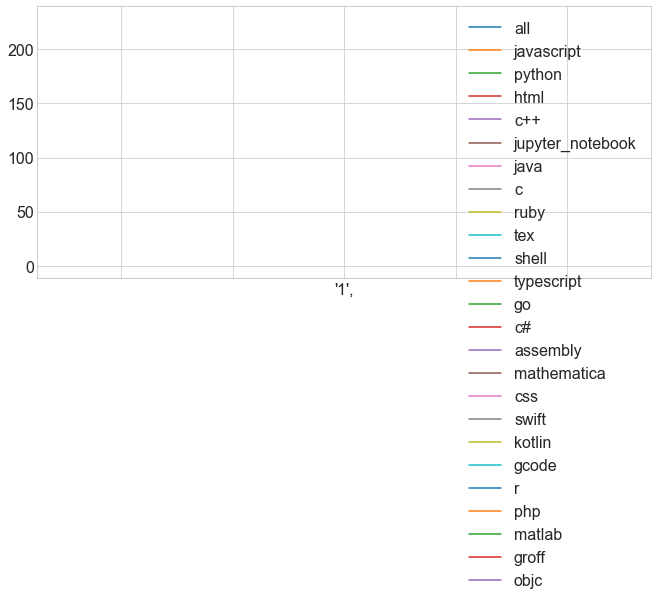

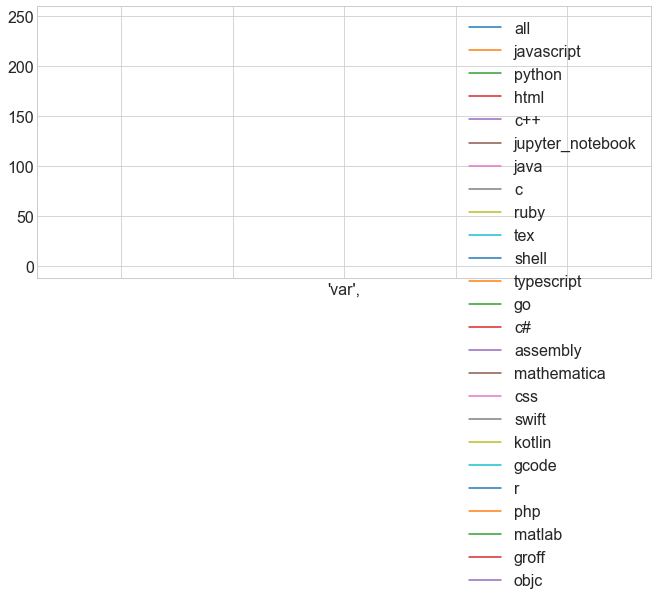

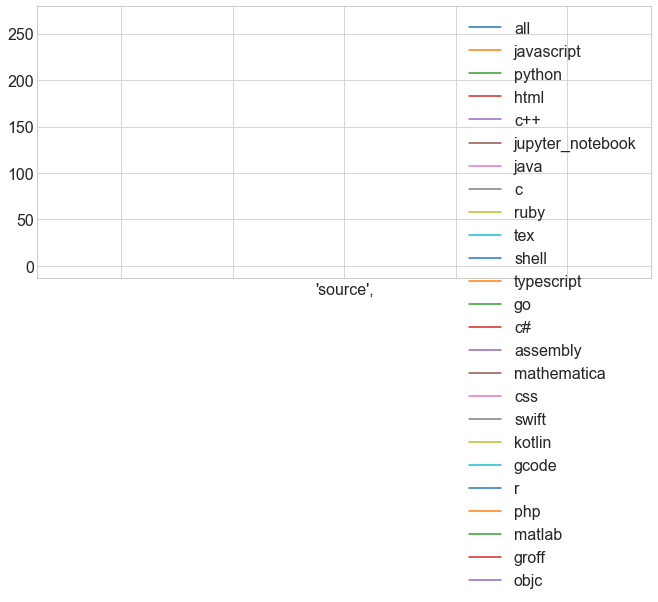

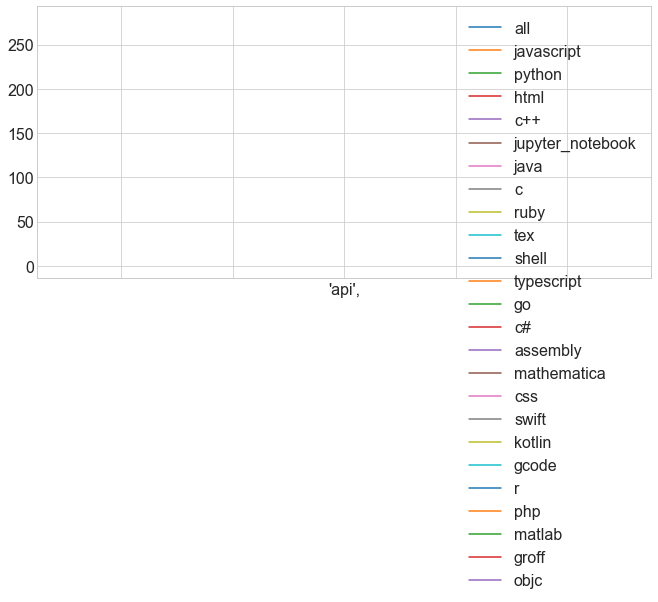

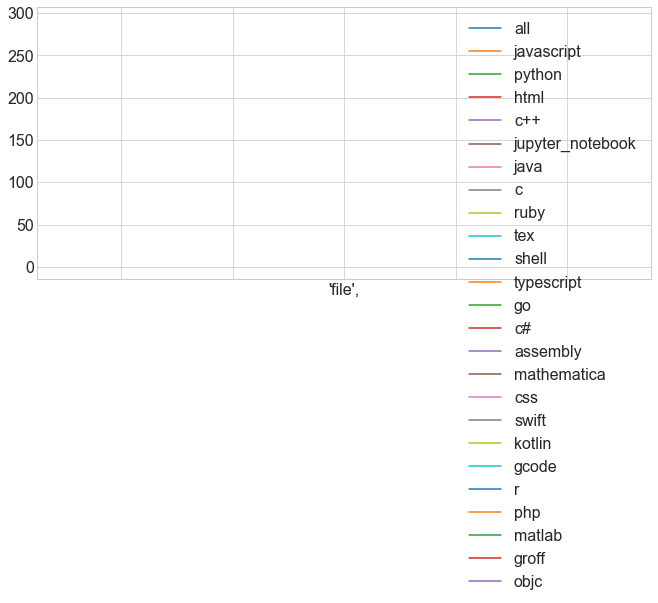

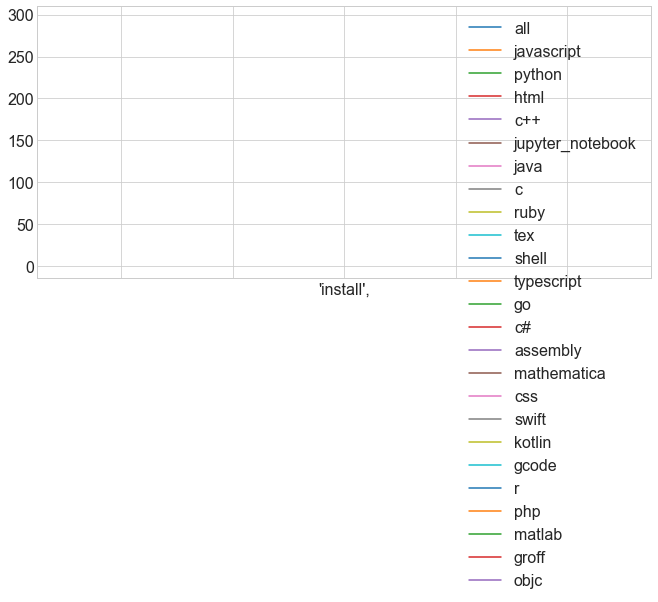

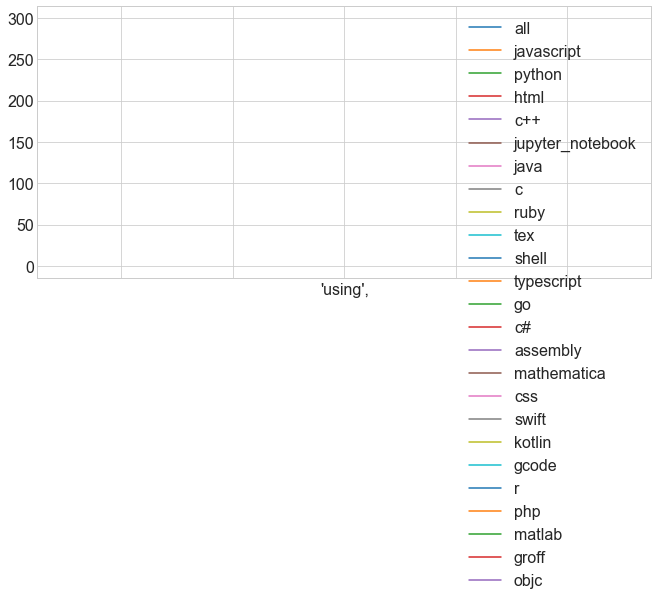

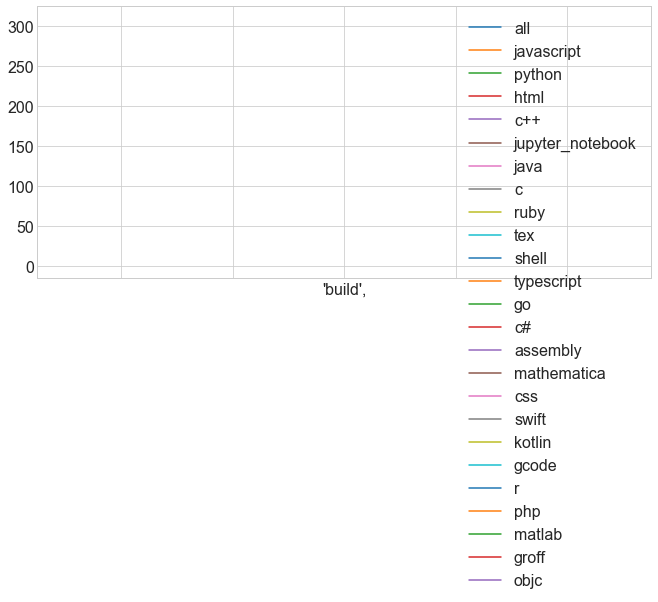

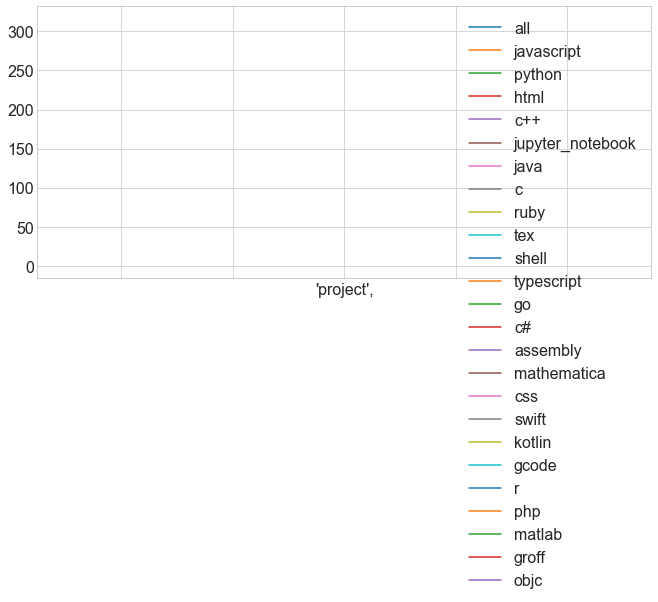

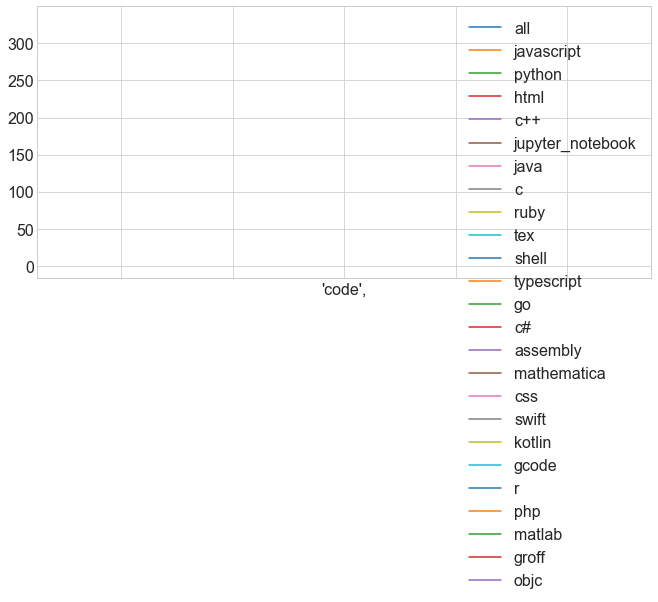

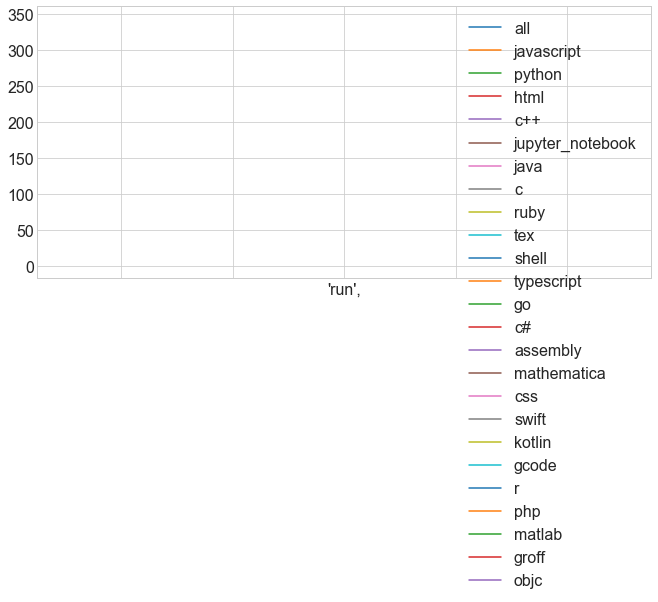

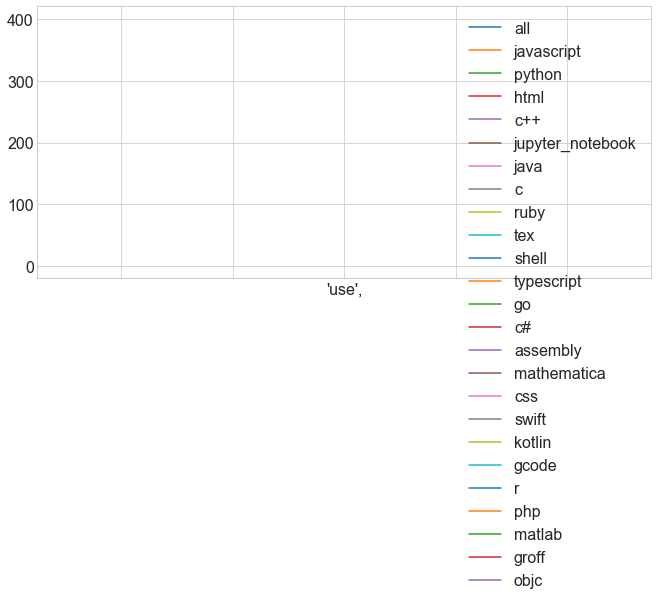

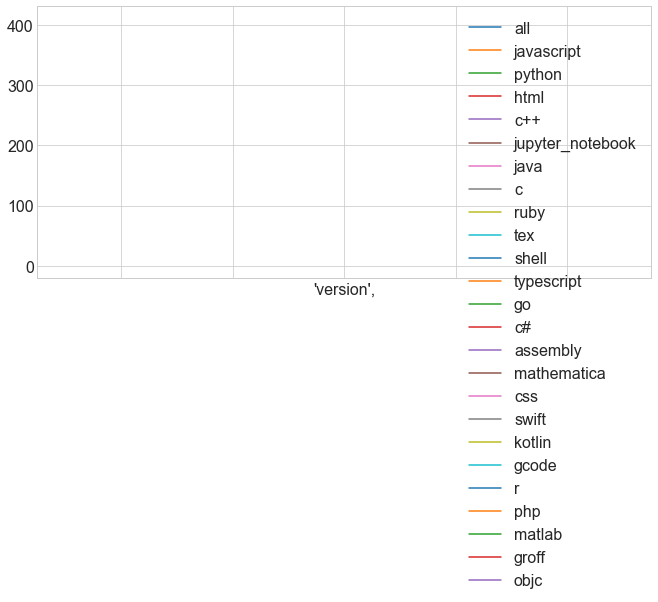

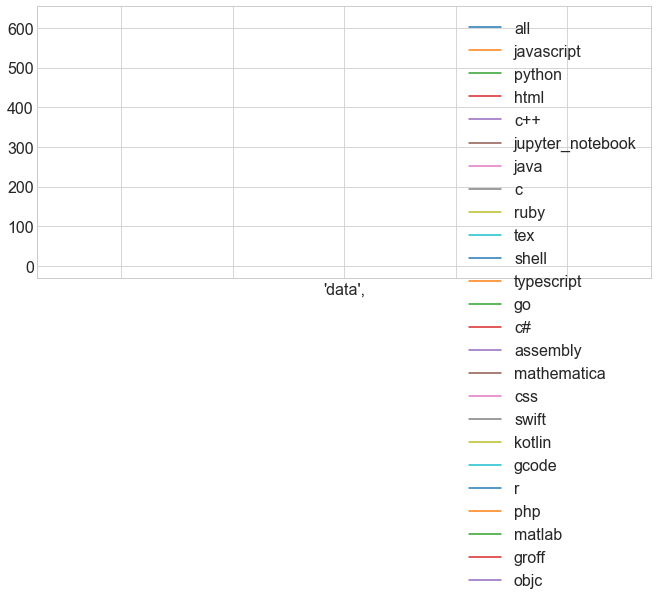

In [39]:
top_25

In [ ]:
df.language.value_counts()

In [ ]:
# Let's build a Bag of Words
cv = CountVectorizer()
bag_of_words = cv.fit_transform(df.clean_text)

In [ ]:
bag_of_words.todense()

In [ ]:
cv.get_feature_names_out()

In [ ]:
cv.vocabulary_